<a href="https://colab.research.google.com/github/VathanakBotraDos/KhmerOCR-Project/blob/main/khmerText_TrOCR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Technical Process Description: Khmer Optical Character Recognition using TrOCR (No Deployment)

---

This document outlines the technical steps for developing and evaluating a Khmer Optical Character Recognition (OCR) system using the TrOCR model, informed by the "Khmer Text Recognition Dataset" and associated Kaggle resources.

---

1. Data Acquisition and Preparation:

Dataset: Utilize the Khmer Text Recognition Dataset from Kaggle.
Splitting: Divide the dataset into training, validation, and testing sets (e.g., 80/10/10 split).
Image Preprocessing: Implement normalization, noise reduction (if needed), deskewing (if needed), and crucial resizing to a fixed height (e.g., 384 pixels) with aspect-ratio-preserving width adjustment and padding.
Text Preprocessing: Normalize character encoding (UTF-8), handle special characters, and create a comprehensive Khmer vocabulary.
Tokenizer: Develop or utilize a Khmer-specific tokenizer (potentially adapting a multilingual one or creating a custom one based on the vocabulary) to map characters to IDs and handle special tokens.

---
2. Model Selection and Initialization:

Architecture: Employ the TrOCR vision encoder-decoder model.
Pre-trained Model: Leverage pre-trained TrOCR weights from Hugging Face Transformers (e.g., microsoft/trocr-base-printed).
Configuration: Load the pre-trained model and configure its decoder vocabulary size to match the Khmer tokenizer.

---
3. Model Fine-tuning:

Data Loaders: Create PyTorch DataLoader instances for efficient batch processing of preprocessed image-text pairs.
Loss and Optimizer: Use Cross-Entropy Loss for text generation and an optimizer like AdamW with a learning rate and potential scheduler.
Training Loop: Train the model for определенное epochs, iterating through the training data, calculating loss, backpropagating gradients, and updating model weights.
Validation: Evaluate the model on the validation set periodically using Character Error Rate (CER) to monitor performance and prevent overfitting. Save the best-performing model checkpoints.
Hyperparameter Tuning: Experiment with training parameters to optimize validation set CER.

---
4. Evaluation:

Metric: Primarily use Character Error Rate (CER) to assess the model's accuracy.
Testing: Evaluate the final trained model on the held-out test set to obtain an unbiased CER score.
Qualitative Analysis: Examine model predictions on sample images to understand error patterns and model behavior.

---
Tools and Libraries:

Python, PyTorch, Hugging Face Transformers, Hugging Face Datasets, Evaluate, PIL (Pillow), NumPy, OS.


# Dataset Extraction from Kaggle

Run code below to mount it into your google drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Upload your kaggle.json

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vbvb00123","key":"8b2f5bea1de16e978c5fb4e282bff7a9"}'}

Move .kaggle to the right dir

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Install Kaggle and download the dataset

In [4]:
!pip install -q kaggle
!kaggle datasets download emhengly/khmer-text-recognition-dataset


Dataset URL: https://www.kaggle.com/datasets/emhengly/khmer-text-recognition-dataset
License(s): apache-2.0


In [5]:
!unzip khmer-text-recognition-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/images/211262.jpg  
  inflating: images/images/211263.jpg  
  inflating: images/images/211265.jpg  
  inflating: images/images/211266.jpg  
  inflating: images/images/211267.jpg  
  inflating: images/images/211268.jpg  
  inflating: images/images/211269.jpg  
  inflating: images/images/211270.jpg  
  inflating: images/images/211271.jpg  
  inflating: images/images/211272.jpg  
  inflating: images/images/211274.jpg  
  inflating: images/images/211275.jpg  
  inflating: images/images/211276.jpg  
  inflating: images/images/211277.jpg  
  inflating: images/images/211278.jpg  
  inflating: images/images/211280.jpg  
  inflating: images/images/211281.jpg  
  inflating: images/images/211282.jpg  
  inflating: images/images/211283.jpg  
  inflating: images/images/211284.jpg  
  inflating: images/images/211287.jpg  
  inflating: images/images/211288.jpg  
  inflating: images/images/211289.jpg  
  inflating: images/images/21

In [ ]:
!ls


drive	kaggle.json			    labels.txt
images	khmer-text-recognition-dataset.zip  sample_data


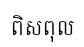

In [10]:
from IPython.display import Image
Image(filename='images/images/086461.jpg')

## TOCR model

The TrOCR (Transformer-based Optical Character Recognition) model is a pretty cool piece of tech designed to recognize text in images. It uses a combination of two Transformers: one for understanding the image and another for generating the text.

Here's a quick rundown:

Image Transformer Encoder: This part of the model processes the image to understand its content. Text Transformer Decoder: This part generates the text from the processed image data. The model is trained in two stages:

Pre-training: It learns from a large amount of synthetic data. Fine-tuning: It gets refined using human-labeled datasets to improve accuracy.

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.2 MB/s eta 0:00:00


In [13]:
!pwd
!ls

/content
drive	kaggle.json			    labels.txt
images	khmer-text-recognition-dataset.zip  sample_data


In [14]:
!ls /content/

drive	kaggle.json			    labels.txt
images	khmer-text-recognition-dataset.zip  sample_data


In [8]:
# 1) Install dependencies
!pip install --quiet tokenizers transformers

# 2) Extract all Khmer text into one corpus file
import os

LABELS_FILE = "/content/labels.txt"  # <--- THIS IS THE CORRECTED LINE
CORPUS_FILE = "khmer_corpus.txt"

# Try opening with a different encoding, e.g., 'latin-1' or 'iso-8859-1'
with open(LABELS_FILE, encoding="latin-1") as fin, open(CORPUS_FILE, "w", encoding="utf-8") as fout:  # <-- Changed encoding here
    for line in fin:
        line = line.strip()
        if not line:
            continue
        # split off the image filename, keep the rest
        _, text = line.split(" ", 1)
        fout.write(text + "\n")

print(f"Wrote corpus with {sum(1 for _ in open(CORPUS_FILE))} lines → {CORPUS_FILE}")



# 3) Train a BPE tokenizer with tokenizers library
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors

# 3.1 Create empty BPE model, reserve special tokens
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=32000,
    special_tokens=["<unk>", "<pad>", "<s>", "</s>"]
)

# 3.2 Train on our Khmer corpus
tokenizer.train([CORPUS_FILE], trainer)

# 3.3 Set up post‑processing so that we wrap sequences in <s> … </s>
tokenizer.post_processor = processors.TemplateProcessing(
    single="<s> $A </s>",
    pair="<s> $A </s> <s> $B </s>",
    special_tokens=[("<s>", tokenizer.token_to_id("<s>")), ("</s>", tokenizer.token_to_id("</s>"))],
)

# 3.4 Save the raw JSON
os.makedirs("khmer_tokenizer", exist_ok=True)
tokenizer_json = os.path.join("khmer_tokenizer", "tokenizer.json")
tokenizer.save(tokenizer_json)
print("Saved raw tokenizer JSON →", tokenizer_json)

# 4) Wrap it in a HuggingFace PreTrainedTokenizerFast and save config
from transformers import PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=tokenizer_json,
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<s>",
    eos_token="</s>",
)

hf_tokenizer.save_pretrained("khmer_tokenizer")
print("HuggingFace tokenizer saved under ./khmer_tokenizer/")

Wrote corpus with 179323 lines → khmer_corpus.txt
Saved raw tokenizer JSON → khmer_tokenizer/tokenizer.json
HuggingFace tokenizer saved under ./khmer_tokenizer/


In [9]:
# 1) Install dependencies
!pip install --quiet tokenizers transformers

# 2) Extract all Khmer text into one corpus file
import os

LABELS_FILE = "/content/labels.txt"  # <--- THIS IS THE CORRECTED LINE
CORPUS_FILE = "khmer_corpus.txt"

# Try opening with a different encoding, e.g., 'latin-1' or 'iso-8859-1'
with open(LABELS_FILE, encoding="latin-1") as fin, open(CORPUS_FILE, "w", encoding="utf-8") as fout:  # <-- Changed encoding here
    for line in fin:
        line = line.strip()
        if not line:
            continue
        # split off the image filename, keep the rest
        _, text = line.split(" ", 1)
        fout.write(text + "\n")

print(f"Wrote corpus with {sum(1 for _ in open(CORPUS_FILE))} lines → {CORPUS_FILE}")



# 3) Train a BPE tokenizer with tokenizers library
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors

# 3.1 Create empty BPE model, reserve special tokens
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=32000,
    special_tokens=["<unk>", "<pad>", "<s>", "</s>"]
)

# 3.2 Train on our Khmer corpus
tokenizer.train([CORPUS_FILE], trainer)

# 3.3 Set up post‑processing so that we wrap sequences in <s> … </s>
tokenizer.post_processor = processors.TemplateProcessing(
    single="<s> $A </s>",
    pair="<s> $A </s> <s> $B </s>",
    special_tokens=[("<s>", tokenizer.token_to_id("<s>")), ("</s>", tokenizer.token_to_id("</s>"))],
)

# 3.4 Save the raw JSON
os.makedirs("khmer_tokenizer", exist_ok=True)
tokenizer_json = os.path.join("khmer_tokenizer", "tokenizer.json")
tokenizer.save(tokenizer_json)
print("Saved raw tokenizer JSON →", tokenizer_json)

# 4) Wrap it in a HuggingFace PreTrainedTokenizerFast and save config
from transformers import PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=tokenizer_json,
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<s>",
    eos_token="</s>",  # Corrected line
)

hf_tokenizer.save_pretrained("khmer_tokenizer")
print("HuggingFace tokenizer saved under ./khmer_tokenizer/")

Wrote corpus with 179323 lines → khmer_corpus.txt
Saved raw tokenizer JSON → khmer_tokenizer/tokenizer.json
HuggingFace tokenizer saved under ./khmer_tokenizer/


In [18]:
!pip uninstall -y torch torchvision torchaudio gcsfs fsspec

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2


In [ ]:
!pip install torch torchvision torchaudio --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [10]:
import fsspec
print(f"fsspec version: {fsspec.__version__}")

fsspec version: 2024.12.0


In [2]:
# 1. Install dependencies (if running on a fresh Kaggle kernel)
!pip install --quiet transformers datasets evaluate

# 2. Imports
import os
from PIL import Image

import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoFeatureExtractor,
    PreTrainedTokenizerFast,
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
from transformers import AutoImageProcessor, TrOCRProcessor
import evaluate

# 3. Paths
LABELS_FILE     = "/content/labels.txt"  # <--- Colab adjustment
IMAGES_FOLDER     = "/content/images/images"  # <--- Colab adjustment (verify this!)
KHMER_TOKENIZER  = "/content/khmer_tokenizer"  # <--- Colab adjustment

# 4. Load your Khmer tokenizer (fast)
tokenizer = PreTrainedTokenizerFast.from_pretrained(KHMER_TOKENIZER, local_files_only=True)

# 5. Prepare the TrOCR processor
# load the vision processor explicitly
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/trocr-base-printed")

# and then build your own TrOCRProcessor
processor = TrOCRProcessor(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)

# 6. Build a HuggingFace Dataset from the labels file
examples = []
with open(LABELS_FILE, encoding="latin-1") as f: # Changed encoding to 'latin-1'
    for line in f:
        line = line.strip()
        if not line:
            continue
        # each line: "<image_filename> <transcription…>"
        fname, text = line.split(" ", 1)
        img_path = os.path.join(IMAGES_FOLDER, fname)
        examples.append({"image_path": img_path, "text": text})


# dataset = Dataset.from_list(examples)
dataset = Dataset.from_list(examples[:1000])  # limit to first 1000

# 90/10 train/eval split
splits  = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = splits["train"]
eval_ds  = splits["test"]

# 7. Preprocessing function and augmented scripts
def preprocess(ex):
    # load & featurize image
    img = Image.open(ex["image_path"]).convert("RGB")

    # --- Data Augmentation using Albumentations ---
    import albumentations as A
    import numpy as np  # Import NumPy

    transform = A.Compose([
        A.Rotate(limit=5, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.3),
        # ... add other augmentations as needed ...
    ])

    img = np.array(img)  # Convert PIL Image to NumPy array
    augmented = transform(image=img)
    img = augmented["image"]
    img = Image.fromarray(img)  # Convert back to PIL Image
    # --- End of Data Augmentation ---


    pixel_values = processor.feature_extractor(
        images=img, return_tensors="np"
    ).pixel_values[0]
    # tokenize text
    labels = tokenizer(
        ex["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    ).input_ids
    return {"pixel_values": pixel_values, "labels": labels}

# Only apply augmentations to the training dataset
train_ds = train_ds.map(preprocess, remove_columns=["image_path", "text"])
# Keep the evaluation dataset un-augmented
eval_ds  = eval_ds.map(preprocess, remove_columns=["image_path", "text"])  # This line was removed in a previous response; keep it here to ensure evaluation dataset isn't augmented

# 8. Collate function for batching
def collate_fn(batch):
    pixel_vals = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    labels     = torch.tensor([x["labels"] for x in batch], dtype=torch.long)
    # ignore pad tokens in loss
    labels[labels == tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_vals, "labels": labels}

# 9. Load and configure the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id        = tokenizer.pad_token_id
model.config.vocab_size             = tokenizer.vocab_size
model.to(device)

# 10. Prepare metrics

# Load the character‐error‐rate metric instead of WER
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_ids  = pred.predictions
    label_ids = pred.label_ids

    # Decode predictions
    preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # Replace -100 labels (ignored tokens) with pad_token_id for decoding
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    refs = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute CER
    cer = cer_metric.compute(predictions=preds, references=refs)

    return {"cer": cer}

# 11. Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir            = "./results",
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    predict_with_generate = True,
    # evaluation_strategy   = "steps",
    # eval_steps          = 500,
    logging_steps         = 100,
    save_steps            = 500,
    save_total_limit      = 2,
    num_train_epochs      = 5,
    learning_rate         = 5e-5,
    fp16                  = torch.cuda.is_available(),
)

# 12. Initialize Trainer
trainer = Seq2SeqTrainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_ds,
    eval_dataset     = eval_ds,
    data_collator    = collate_fn,
    tokenizer        = tokenizer,
    compute_metrics  = compute_metrics,
)

# 13. Train!
trainer.train()

# 14. Save the fine‑tuned model + processor
trainer.save_model("./khmer_trocr_trained")
processor.save_pretrained("./khmer_trocr_trained")

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:55: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-2-8fb7489f8599>:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: botracgcc (botracgcc-american-university-of-phnom-penh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.454600
200,1.511400
300,1.107900
400,0.729800
500,0.440200


[]

Another code but time augmented and add more epoch also train more picture

In [ ]:
# 1. Install dependencies
!pip install --quiet transformers datasets evaluate albumentations

# 2. Imports
import os
from PIL import Image

import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoFeatureExtractor,
    PreTrainedTokenizerFast,
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
from transformers import AutoImageProcessor, TrOCRProcessor
import evaluate
import albumentations as A

# 3. Paths
LABELS_FILE = "/content/labels.txt"
IMAGES_FOLDER = "/content/images/images"
KHMER_TOKENIZER = "/content/khmer_tokenizer"
RESULTS_DIR = "/content/results"  # Directory to store results and track trained images

# 4. Load your Khmer tokenizer (fast)
tokenizer = PreTrainedTokenizerFast.from_pretrained(KHMER_TOKENIZER, local_files_only=True)

# 5. Prepare the TrOCR processor
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/trocr-base-printed")
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# 6. Build a HuggingFace Dataset, select last 1000, and avoid redundant learning
examples = []
with open(LABELS_FILE, encoding="latin-1") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        fname, text = line.split(" ", 1)
        img_path = os.path.join(IMAGES_FOLDER, fname)
        examples.append({"image_path": img_path, "text": text})

additional_training_examples = examples[-1000:]

def has_been_trained(image_path, results_dir=RESULTS_DIR):
    """Checks if an image has been used in previous training."""
    image_filename = os.path.basename(image_path)
    trained_images_dir = os.path.join(results_dir, "trained_images")
    os.makedirs(trained_images_dir, exist_ok=True)
    trained_images_file = os.path.join(trained_images_dir, "trained_images.txt")

    trained_filenames = []
    if os.path.exists(trained_images_file):
        with open(trained_images_file, "r") as f:
            trained_filenames = [line.strip() for line in f]

    if image_filename in trained_filenames:
        return True

    with open(trained_images_file, "a") as f:
        f.write(image_filename + "\n")
    return False

filtered_examples = [
    ex
    for ex in additional_training_examples
    if not has_been_trained(ex["image_path"])
]

dataset = Dataset.from_list(filtered_examples)

splits = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = splits["train"]
eval_ds = splits["test"]

# 7. Preprocessing function with heavy augmentations
def preprocess(ex):
    img = Image.open(ex["image_path"]).convert("RGB")

    transform = A.Compose([
        A.Rotate(limit=15, p=0.8),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
        A.GaussianBlur(blur_limit=(3, 7), p=0.8),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=10, p=0.8),
        A.RandomShadow(p=0.5),
        A.RandomSunFlare(p=0.5, src_radius=100),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    ])

    img = np.array(img)
    augmented = transform(image=img)
    img = augmented["image"]
    img = Image.fromarray(img)

    pixel_values = processor.feature_extractor(images=img, return_tensors="np").pixel_values[0]
    labels = tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128).input_ids
    return {"pixel_values": pixel_values, "labels": labels}

train_ds = train_ds.map(preprocess, remove_columns=["image_path", "text"])
eval_ds = eval_ds.map(preprocess, remove_columns=["image_path", "text"])

# 8. Collate function for batching
def collate_fn(batch):
    pixel_vals = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    labels = torch.tensor([x["labels"] for x in batch], dtype=torch.long)
    labels[labels == tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_vals, "labels": labels}

# 9. Load and configure the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = tokenizer.vocab_size
model.to(device)

# 10. Prepare metrics
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    refs = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=preds, references=refs)
    return {"cer": cer}

# 11. Training arguments with increased epochs
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    num_train_epochs=6,  # Increased to 6 epochs
    learning_rate=5e-5,
    fp16=torch.cuda.is_available(),
)

# 12. Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=collate_fn,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 13. Train!
trainer.train()

# 14. Save the fine-tuned model + processor
trainer.save_model("./khmer_trocr_trained")
processor.save_pretrained("./khmer_trocr_trained")

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

Step,Training Loss
100,2.536300
200,1.729200
300,1.591700
400,1.510400
500,1.284200


# Evaluation Section

This part of the code is for taking a peek at the data we're using to check how well our model is doing. It grabs a few images from the set aside for testing, shows you the images, and then prints out the actual text that's supposed to be in those images. This helps us make sure everything looks right and gives us a sense of what the model will be working with when we test it.

Small Evaluation

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod


--- Faster Evaluation (Adjusted Parameters) ---
Average CER (fast eval): 1.3951648351648351
Evaluation Time: 42.59 seconds
Total time taken for evaluation: 44.04 seconds
Image 1:
  Prediction: á á á á á á á á á á á á á á á á á á á á
  Ground Truth: áá·ááá»á


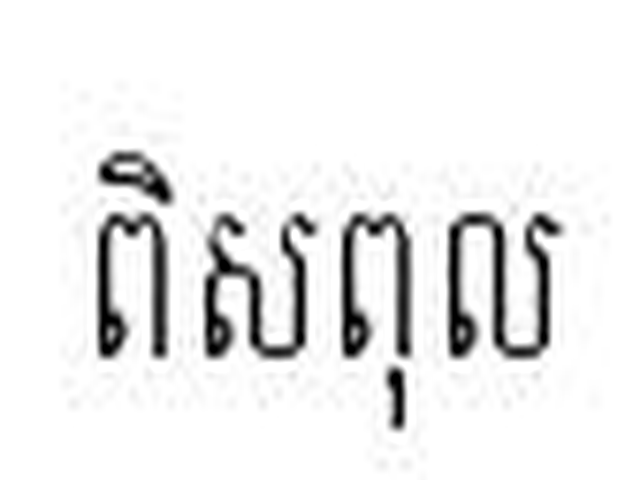

Image 2:
  Prediction: á á á á á á á á á á á á á á á á á á á á
  Ground Truth: á¢á¼ááá


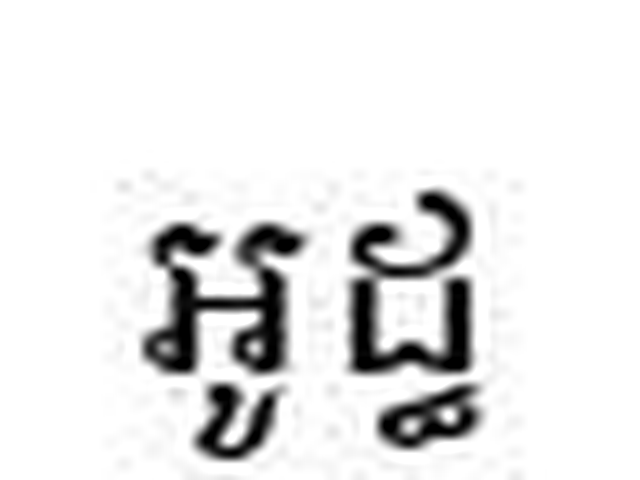

Image 3:
  Prediction: á á á á á á á á á á á á á á á á á á á á
  Ground Truth: áááá¶áááá


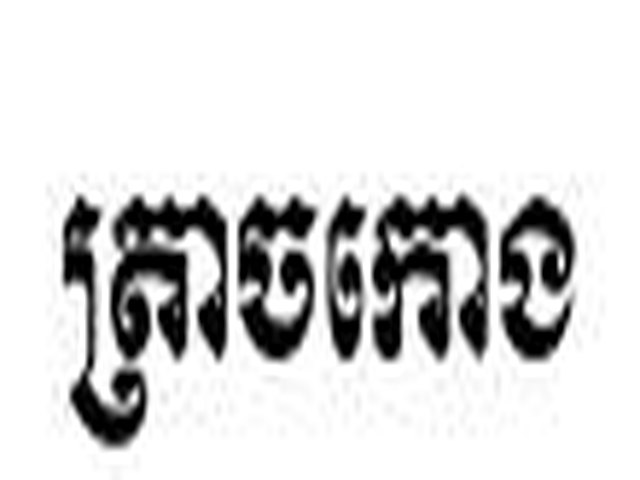

Image 4:
  Prediction: á á á á á á á á á á á á á á á á á á á á
  Ground Truth: áááááºáá


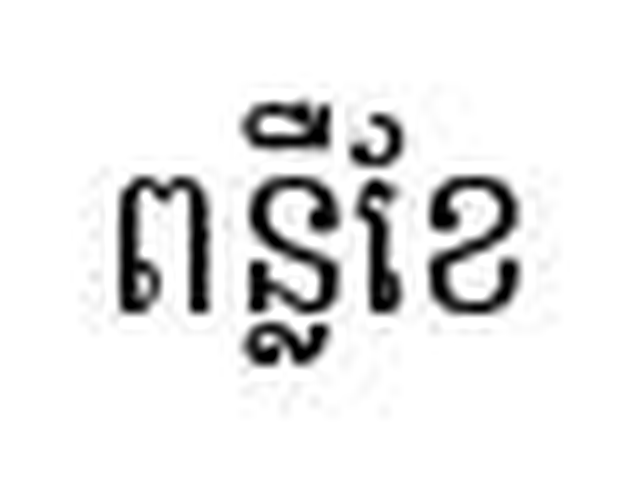

Image 5:
  Prediction: á á á á á á á á á á á á á á á á á á á á
  Ground Truth: áááááááá¸


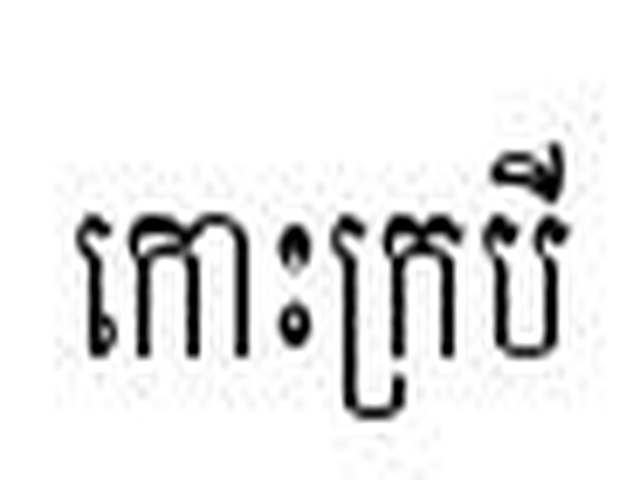

In [7]:
import os
from IPython.display import display
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import evaluate
import torch
import time  # For timing the evaluation
from datasets import Dataset


def full_evaluate_trocr_fast(model_path, processor_path, dataset, num_samples=None, resize_height=None, resize_width=None):
    """
    Evaluates a TrOCR model on a dataset and calculates Character Error Rate (CER),
    optimized for speed.

    Args:
        model_path (str): Path to the trained TrOCR model.
        processor_path (str): Path to the trained TrOCR processor.
        dataset (Dataset): Hugging Face Dataset to evaluate on.
        num_samples (int, optional): Number of samples to evaluate on.
                                     If None, evaluates on a default subset (e.g., 200).
        resize_height (int, optional):  Height to resize images to (for faster processing).
        resize_width (int, optional): Width to resize images to (for faster processing).

    Returns:
        float: Average Character Error Rate (CER) on the evaluation set.
        dict:  Dictionary containing each prediction and its corresponding ground truth.
        float: Total evaluation time.
    """

    # 1. Load Processor and Model
    processor = TrOCRProcessor.from_pretrained(processor_path)
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # 2. Prepare CER metric
    cer_metric = evaluate.load("cer")

    predictions = []
    ground_truths = []

    # Determine the number of samples to process
    if num_samples is None:
        eval_dataset = dataset.select(range(min(200, len(dataset))))  # Default to 200 or dataset size
    else:
        eval_dataset = dataset.select(range(min(num_samples, len(dataset))))

    start_time = time.time()  # Start timing

    # 3. Iterate through the dataset and perform evaluation
    for i, example in enumerate(eval_dataset):
        # Load and preprocess image
        image = Image.open(example["image_path"]).convert("RGB")

        # Resize image if specified
        if resize_height and resize_width:
            image = image.resize((resize_width, resize_height), Image.Resampling.LANCZOS)

        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

        # Generate prediction
        with torch.no_grad():  # Disable gradient calculation for faster inference
            generated_ids = model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Get ground truth label
        label = example["text"]

        predictions.append(predicted_text)
        ground_truths.append(label)

    end_time = time.time()  # End timing
    total_time = end_time - start_time

    # 4. Calculate CER
    cer = cer_metric.compute(predictions=predictions, references=ground_truths)

    return cer, {"predictions": predictions, "ground_truths": ground_truths}, total_time


if __name__ == '__main__':
    # --- Configuration ---
    model_path = "./khmer_trocr_trained"  # Replace with your trained model path
    processor_path = "./khmer_trocr_trained"  # Replace with your trained processor path
    dataset_path = "/content/labels.txt"
    images_folder = "/content/images/images"  # <--- CORRECTED PATH!

    # --- Load dataset ---
    examples = []
    # Changed encoding to 'latin-1' to handle potential encoding issues
    with open(dataset_path, encoding="latin-1") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            fname, text = line.split(" ", 1)
            img_path = os.path.join(images_folder, fname)
            examples.append({"image_path": img_path, "text": text})

    eval_dataset = Dataset.from_list(examples)

    # --- Faster Evaluation ---
    print("\n--- Faster Evaluation (Adjusted Parameters) ---")
    start_eval_time = time.time()
    cer_fast, results_fast, eval_time = full_evaluate_trocr_fast(
        model_path, processor_path, eval_dataset,
        num_samples=100,  # Evaluate on a subset
        resize_height=480,  # Resize images (adjust as needed)
        resize_width=640
    )
    end_eval_time = time.time()
    print(f"Average CER (fast eval): {cer_fast}")
    print(f"Evaluation Time: {eval_time:.2f} seconds")
    print(f"Total time taken for evaluation: {end_eval_time - start_eval_time:.2f} seconds")

    # --- Display some results ---
    for i in range(min(5, len(results_fast['predictions']))):  # Display up to 5
        print(f"Image {i+1}:")
        print(f"  Prediction: {results_fast['predictions'][i]}")
        print(f"  Ground Truth: {results_fast['ground_truths'][i]}")
        try:
            image = Image.open(eval_dataset[i]["image_path"]).convert("RGB")
            display(image.resize((640, 480), Image.Resampling.LANCZOS)) # Display resized image
        except FileNotFoundError:
            print(f"  Image file not found: {eval_dataset[i]['image_path']}")

Testing a document

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

Predicted Text:
ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង ស្វាយតាវង


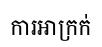

In [ ]:
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import io  # For handling file bytes

# --- Configuration ---
processor_path = "./khmer_trocr_trained"  # Or the path to your trained processor
model_path = "./khmer_trocr_trained"  # Or the path to your trained model
# image_path = "/content/your_document_image.jpg"  # <--- REMOVE THIS!

# --- Load Processor and Model ---
processor = TrOCRProcessor.from_pretrained(processor_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# --- Function to Perform OCR on an Image ---
def perform_ocr(image):
    """
    Performs OCR on a PIL Image object.

    Args:
        image (PIL.Image.Image): The image to process.

    Returns:
        str: The predicted text.
    """
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return predicted_text

# --- Example Usage (Replace with your actual image loading) ---

# 1. From a file path:
# image_path = "/content/my_khmer_image.png"
# image = Image.open(image_path).convert("RGB")

# 2. From an uploaded file (e.g., using ipywidgets - as in the previous example):
# image = Image.open(io.BytesIO(uploaded_file_content)).convert("RGB")

# Replace this with your actual image loading code
# For demonstration purposes, let's load a sample image
# (You'll likely replace this with your file upload/loading method)
image_path = "/content/images/images/051959.jpg"  # Replace with a VALID path for testing
image = Image.open(image_path).convert("RGB")

predicted_text = perform_ocr(image)

# --- Print Results ---
print("Predicted Text:")
print(predicted_text)

# --- Display Image (Optional) ---
display(image)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Uploaded File: photo_6073304806082069757_y.jpg
  Predicted Text: ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ ជុំ


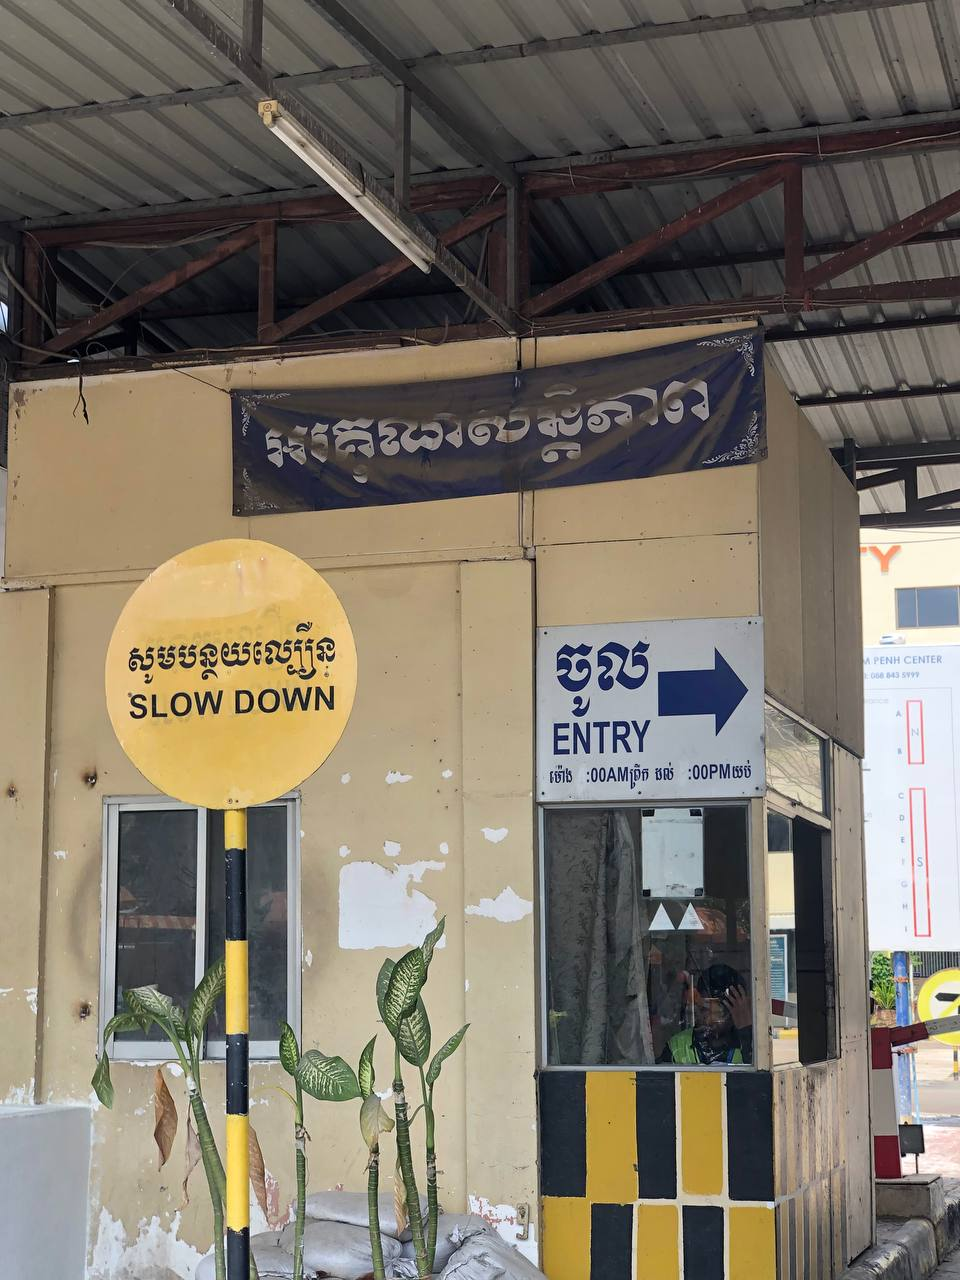

In [ ]:
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import os
import ipywidgets as widgets
from IPython.display import display
import io

# --- Configuration ---
processor_path = "./khmer_trocr_trained"  # Or the path to your trained processor
model_path = "./khmer_trocr_trained"  # Or the path to your trained model

# --- Load Processor and Model ---
processor = TrOCRProcessor.from_pretrained(processor_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def perform_ocr(image):
    """Performs OCR on a PIL Image object."""
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return predicted_text

# --- A. Loading from a Directory ---
def test_from_directory(image_dir):
    """Performs OCR on all images in a directory."""
    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path).convert("RGB")
                predicted_text = perform_ocr(image)
                print(f"File: {filename}")
                print(f"  Predicted Text: {predicted_text}")
                display(image)  # Display the image
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# --- B. Uploading Images with ipywidgets ---
def test_with_upload():
    """Allows users to upload images and performs OCR."""
    upload = widgets.FileUpload(accept='image/*', multiple=True)
    display(upload)

    def process_upload(change):
        for filename, data in upload.value.items():
            try:
                image = Image.open(io.BytesIO(data['content'])).convert("RGB")
                predicted_text = perform_ocr(image)
                print(f"Uploaded File: {filename}")
                print(f"  Predicted Text: {predicted_text}")
                display(image)  # Display the image
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    upload.observe(process_upload, names=['_counter'])

# --- C. Loading from a List of Paths ---
def test_from_path_list(image_paths):
    """Performs OCR on images specified in a list of file paths."""
    for image_path in image_paths:
        try:
            image = Image.open(image_path).convert("RGB")
            predicted_text = perform_ocr(image)
            print(f"File: {os.path.basename(image_path)}")  # Print only the filename
            print(f"  Predicted Text: {predicted_text}")
            display(image)  # Display the image
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# --- Choose your testing method ---
# A. Test from a directory
# test_from_directory("/path/to/your/image/directory")  # Replace with your directory path

# B. Test with file upload
test_with_upload()

# C. Test from a list of paths
# image_paths = ["/path/to/image1.jpg", "/path/to/image2.png", ...]  # Replace with your list
# test_from_path_list(image_paths)

# New Section


### Improvement recommendation:

1. Training on the full dataset.

2. Implementing robust data augmentation techniques.

3. Reviewing your training configuration (learning rate, number of epochs, etc.).

4. Ensuring the Khmer tokenizer is correctly handling the script.

